<a href="https://colab.research.google.com/github/kiselpd/HW4_ML/blob/main/dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#for my GoogleDisk
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/GoogleColab/HW4

Mounted at /content/drive
/content/drive/MyDrive/GoogleColab/HW4


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [2]:

url = 'https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture06/data/news.csv' 
df = pd.read_csv(url, encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [3]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [4]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [5]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [6]:
import nltk

In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

--2022-05-22 13:20:47--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.241, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cachev2-mskm914.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-05-22 13:20:47--  https://cachev2-mskm914.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm914.cdn.yandex.net (cachev2-mskm914.cdn.yandex.net)... 5.45.220.114, 2a02:6b8:0:2002::925
Connecting to cachev2-mskm914.cdn.yandex.net (cachev2-mskm914.cdn.yandex.net)|5.45.220.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linu

In [9]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 6.39 s, sys: 338 ms, total: 6.72 s
Wall time: 48.1 s


In [10]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)

In [11]:
df.text[0] # так выгладит первая статья после предобработки

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [13]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [14]:
vect = TfidfVectorizer()
texts = df.text.values

In [18]:
tfidf_matrix = vect.fit_transform(texts)

In [19]:
S = pairwise_distances(tfidf_matrix, metric = "cosine")
print(S)

[[0.         0.44039199 0.38633479 ... 0.94398897 0.94458814 0.95017696]
 [0.44039199 0.         0.48605077 ... 0.98776795 0.96719975 0.97670289]
 [0.38633479 0.48605077 0.         ... 0.92656443 0.95028574 0.93048104]
 ...
 [0.94398897 0.98776795 0.92656443 ... 0.         0.74550185 0.81097833]
 [0.94458814 0.96719975 0.95028574 ... 0.74550185 0.         0.82184039]
 [0.95017696 0.97670289 0.93048104 ... 0.81097833 0.82184039 0.        ]]


[[], []]

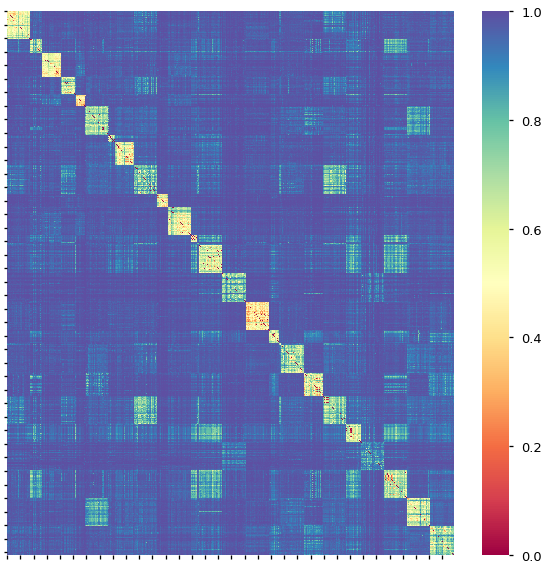

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
clustering_model = DBSCAN(metric = "cosine", eps = 0.65)
clustering_model.fit(tfidf_matrix)

DBSCAN(eps=0.65, metric='cosine')

In [ ]:
labels = clustering_model.labels_
print(labels)

[0 0 0 ... 1 1 1]


In [ ]:
df_labels = pd.DataFrame(labels, columns = ['label']) 
print(df_labels.value_counts()) 

label
 1       746
 8       169
-1       143
 12      100
 0        99
 10       99
 14       99
 11       93
 3        84
 7        82
 4        61
 9        49
 5        41
 6        26
 15       20
 16        8
 13        6
 2         5
dtype: int64


In [ ]:
pd.crosstab(df.loc[:, 'class'], labels)

col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
class,,,,,,,,,,,,,,,,,,
Важные мировые события,5,0,268,5,84,0,41,0,0,0,0,0,0,0,0,0,0,0
Внутренняя политика РФ,8,99,157,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0
Внутренняя политика РФ: оппозиция,41,0,0,0,0,61,0,0,0,169,0,0,0,0,6,0,0,0
Внутренняя политика: культура,1,0,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0
Международные отношения,3,0,124,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0
Международные отношения: Криминальная хроника,0,0,0,0,0,0,0,0,82,0,0,0,0,0,0,0,0,0
Проишествия РФ,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0,0
Спорт,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,8
Спорт,9,0,0,0,0,0,0,0,0,0,0,0,93,0,0,0,0,0


In [ ]:
true_labels = df["class"]
print(true_labels)

0       Внутренняя политика РФ
1       Внутренняя политика РФ
2       Внутренняя политика РФ
3       Внутренняя политика РФ
4       Внутренняя политика РФ
                 ...          
1925    Внутренняя политика РФ
1926    Внутренняя политика РФ
1927    Внутренняя политика РФ
1928    Внутренняя политика РФ
1929    Внутренняя политика РФ
Name: class, Length: 1930, dtype: object


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

In [ ]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_labels)
print(true_labels)

[1 1 1 ... 1 1 1]


In [ ]:
adjusted_rand_score(true_labels, labels)

0.3415716771657879

In [ ]:
#просмотреть кластеризацию DBSCAN для статей

def print_different_articles(labels, df):

  index = np.argwhere(labels == -1)
  labels = np.delete(labels, index)

  for i in range(0, len(np.unique(labels))):
    itemindex = np.where(df["class"] == i)
    print(i, " cluster: ", df.text[itemindex[0][0]])
    print(i, " cluster: ", df.text[itemindex[0][1]])


In [ ]:
df_show = df.drop(["class"], axis = 1)
df_show.loc[:, "class"] = labels

print_different_articles(labels, df_show)

0  cluster:  петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский 

In [ ]:
#0 cluster - внутренняя политика РФ
#1 cluster - важные мировые события
#2 cluster - важные мировые события
#3 cluster - важные мировые события
#4 cluster - внутренняя политика РФ: опозиция
#5 cluster - важные мировые события
#6 cluster - международные отношения
#7 cluster - международные отношения: криминальная хроника
#8 cluster - внутренняя политика РФ: опозиция
#9 cluster - технологии
#10 cluster - культура
#11 cluster - спорт
#12 cluster - внутренняя политика РФ
#13 cluster - внутренняя политика РФ: опозиция
#14 cluster - происшествия РФ
#15 cluster - спорт
#16 cluster - про технику, но из-за упоминания спорта она относится к спорту в изначальном df
# отдельного кластера для терактов нет, так как модель присоединила эту тематику к кластерам с важными мировыми новостями и внутренней политикой РФ